Imports

In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn import svm, tree
from sklearn.model_selection import KFold,cross_val_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix, hstack




Opening Json Processed Dataset

In [2]:
dataset = pd.read_json("drive/My Drive/ML/HW1/processed_dataset.json",lines=True)


Count Vectorizer: fitted with the instructions

In [3]:
vectorizer = CountVectorizer(min_df=0.005) # multinomial

X1= vectorizer.fit_transform(dataset['instructions'])
y_all = dataset['semantic']


Adding control flow graph features

In [4]:
columns=vectorizer.get_feature_names()

#adding number of edges
edges=dataset['edges']
l=len(edges)
rows=np.arange(0,l)
cols=np.full((l), 0, dtype=int)
X2=csr_matrix((edges, (rows, cols)),shape=(l, 1)).toarray()
X_tmp2=hstack((X1,X2))
columns.append('edges')

#adding cycles(true/false)
cycles=dataset['cycles']
X3=csr_matrix((cycles, (rows, cols)),shape=(l, 1)).toarray()
X_tmp=hstack((X_tmp2,X3))
columns.append('has_cycles')


#adding cyclomatic complexity
cyclo=dataset['cyclomatic']
X4=csr_matrix((cyclo, (rows, cols)),shape=(l, 1)).toarray()
X_all=hstack((X_tmp,X4))
columns.append('cyclomatic_c')

print(X_all.shape)
print(pd.DataFrame(X_all.A[0:10], columns=columns).to_string())


(14397, 51)
   add  and  bswap  bt  byte  call  cdq  cdqe  cmov  cmp  dec  div  dword  float  idiv  imul  inc  jmp  jumpc  lea  leave  mov  movs  movz  neg  nop  not  or  pand  pinsrw  pop  por  pshufd  punp  push  pxor  qword  ret  rol  ror  sbb  set  shift  sub  test  ucomiss  xmm  xor  edges  has_cycles  cyclomatic_c
0    8    0      0   0     1    12    0     0     0   16    0    0      9      0     0     0    0   14     16    0      0   92     8     0    0    0    0   0     0       0    4    0       0     0     4     0     16    4    0    0    0    0      0    2     0        0    0    0     30           0             8
1    0    0      0   0     0     2    0     0     0    0    0    0      0     22     0     0    0    6     18    0      0   12     4     0    0    0    0   0     0       0    0    0       0     0     4     8      0    4    0    0    0    0      0    2     8        0   21    0     20           0             6
2   24  102      0   0    58     0    0     4     2   32  

Split Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
          test_size=0.3, random_state=15)

print("Train: %d - Test: %d" %(X_train.shape[0],X_test.shape[0]))

Train: 10077 - Test: 4320


Choose a Model

In [6]:
model_type = "SVM" 

if model_type == "bernoulli":
  start=time.time()
  model = BernoulliNB().fit(X_train, y_train)
  t=time.time()-start
  print("training running time: "+str(t)+" sec")

elif model_type == "multinomial":
  start=time.time()
  model = MultinomialNB().fit(X_train, y_train)
  t=time.time()-start
  print("training running time: "+str(t)+" sec")

elif model_type == "SVM":
  start=time.time()
  model = svm.SVC(kernel = 'linear', C=1).fit(X_train, y_train)
  t=time.time()-start
  print("training running time: "+str(t)+" sec")




training running time: 31.82270312309265 sec


Evaluate the chosen model

In [7]:
y_pred = model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
print("accuracy_score: "+str(accuracy_score(y_test,y_pred, normalize=True)))

[[ 806    0    4    0]
 [   0 1384   11    0]
 [   0    2 1173   12]
 [   0    0   52  876]]
              precision    recall  f1-score   support

  encryption       1.00      1.00      1.00       810
        math       1.00      0.99      1.00      1395
        sort       0.95      0.99      0.97      1187
      string       0.99      0.94      0.96       928

    accuracy                           0.98      4320
   macro avg       0.98      0.98      0.98      4320
weighted avg       0.98      0.98      0.98      4320

accuracy_score: 0.98125


Plot the confusion Matrix

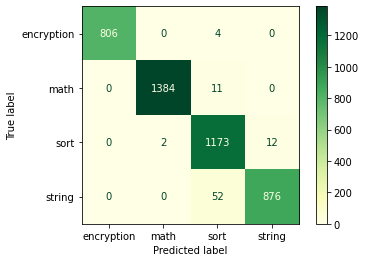

In [8]:
plot_confusion_matrix(model,X_test, y_test,values_format='d',cmap=plt.cm.YlGn)

5-Fold Cross Validation 

[0.98611111 0.98402778 0.98680556 0.9875     0.98125    0.98333333
 0.98402778 0.98888117 0.98123697 0.98332175]


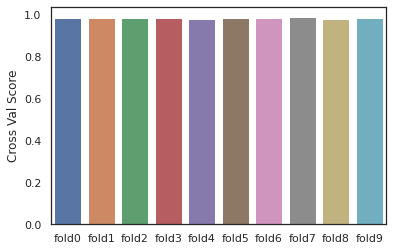

In [14]:
#cv = ShuffleSplit(n_splits=5, test_size=0.333, random_state=15)
cv = KFold(n_splits=10)
model=svm.SVC(kernel = 'linear', C=1)
#model=MultinomialNB()
scores = cross_val_score(model, X_all, y_all, cv=cv)

print(scores)
a_scores = pd.DataFrame(scores,columns=['Cross Val Score'])
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['fold0','fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9'],y="Cross Val Score",data=a_scores)
plt.show()
sns.set()